In [22]:
import numpy as np
from model_vae import CVAE,cvae_loss
from vae_earlystopping import EarlyStopping
import torch
import pandas as pd
metal_df = np.load('./data/metal.npy')[:,1:]
react_df = np.load('./data/reaction.npy')

In [7]:
import os, sys
PATH = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(PATH,'..'))

import model_vae

In [ ]:
import vae

In [23]:
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(metal_df,react_df,random_state =21,test_size=0.4)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,random_state = 21,test_size =0.5)

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_c = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
c_train = scaler_c.fit_transform(c_train)
x_val,x_test = [scaler_x.transform(x) for x in [x_val,x_test]]
c_val,c_test = [scaler_c.transform(c) for c in [c_val,c_test]]

In [25]:
all_data = [x_train,x_val,x_test,c_train,c_val,c_test]
x_train,x_val,x_test,c_train,c_val,c_test = [torch.tensor(x,dtype = torch.float32) for x in all_data]

In [26]:
type(x_train)

torch.Tensor

In [27]:
from torch.utils.data import TensorDataset,DataLoader
train_data = [x_train,c_train]
val_data= [x_val,c_val]
test_data = [x_test,c_test]
train_data,val_data,test_data = [TensorDataset(*x) for x in [train_data,val_data,test_data]]

In [28]:
batch_size = 64
train_loader,val_loader,test_loader = [DataLoader(x,batch_size = batch_size, shuffle=False) for x in [train_data,val_data,test_data]]

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_dim = x_train.shape[1]
c_dim = c_train.shape[1]
model = CVAE(x_dim,c_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [30]:
epochs = 300
train_losses = []
val_losses = []
early = EarlyStopping(patience=30, min_delta=1e-4)
for epoch in range(1, epochs+1):
    model.train()
    total_train_loss = 0.0
    for batch_x,batch_c in train_loader:
        batch_x = batch_x.to(device)
        batch_c = batch_c.to(device)
        x_hat,mu,logvar = model(batch_x,batch_c)
        loss,recon,kl = cvae_loss(x_hat,batch_x,mu,logvar,beta = 0.01)
        total_train_loss +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss/len(train_loader)
    # --val
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)
            v_x_hat,v_mu,v_logvar = model(v_x,v_c)
            v_loss,v_recon,v_kl = cvae_loss(v_x_hat,v_x,v_mu,v_logvar,beta=0.01)
            total_val_loss +=v_loss.item()
    avg_val_loss = total_val_loss/len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    if epoch % 20 ==0 or epoch ==1:
        print(f'[{epoch}/{epochs}] train_loss:{avg_train_loss:.4f},val_loss:{avg_val_loss:.4f}')
    stop= early.step(avg_val_loss,model)
    if early.best_state is not None and avg_val_loss == early.best:
        best_epoch = epoch
    if stop:
        print(f'Early_stopping at {epoch},best_epoch = {best_epoch}, val_loss:{early.best:.4f}')
        break

[1/300] train_loss:0.1387,val_loss:0.0246
[20/300] train_loss:0.0044,val_loss:0.0048
[40/300] train_loss:0.0043,val_loss:0.0047
[60/300] train_loss:0.0040,val_loss:0.0045
[80/300] train_loss:0.0039,val_loss:0.0044
[100/300] train_loss:0.0038,val_loss:0.0043
[120/300] train_loss:0.0037,val_loss:0.0041
[140/300] train_loss:0.0036,val_loss:0.0040
[160/300] train_loss:0.0035,val_loss:0.0039
[180/300] train_loss:0.0034,val_loss:0.0038
[200/300] train_loss:0.0032,val_loss:0.0037
[220/300] train_loss:0.0031,val_loss:0.0036
[240/300] train_loss:0.0031,val_loss:0.0035
[260/300] train_loss:0.0030,val_loss:0.0035
Early_stopping at 272,best_epoch = 242, val_loss:0.0035


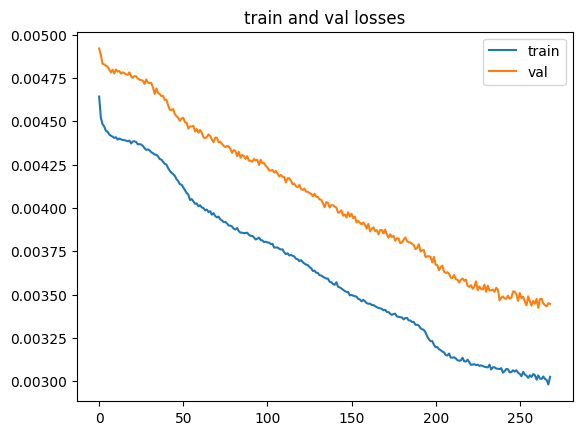

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_losses[3:],label ='train')
plt.plot(val_losses[3:], label = 'val')
plt.title('train and val losses')
plt.legend()
plt.show()

In [32]:
model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()

x_true_list = []
x_hat_list = []

with torch.no_grad():
    for x_test, c_test in test_loader:
        x_test = x_test.to(device)
        c_test = c_test.to(device)

        x_hat_test, test_mu, test_logvar = model(x_test, c_test)

        # GPU → CPU → numpy
        x_true_np = x_test.detach().cpu().numpy()
        x_hat_np = x_hat_test.detach().cpu().numpy()

        x_true_list.append(x_true_np)
        x_hat_list.append(x_hat_np)

# 🔹 test_loader 전체를 하나로 합침
x_true_test_np = np.concatenate(x_true_list, axis=0)
x_hat_test_np  = np.concatenate(x_hat_list, axis=0)

# 🔹 원래 스케일로 복원
x_true_test = scaler_x.inverse_transform(x_true_test_np)
x_hat_test  = scaler_x.inverse_transform(x_hat_test_np)

print(x_true_test.shape, x_hat_test.shape)


(1182, 23) (1182, 23)


In [33]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,2:25].columns

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

rmse = np.sqrt(mean_squared_error(x_true_test, x_hat_test))
mse = mean_squared_error(x_true_test,x_hat_test)
r2 = r2_score(x_true_test.flatten(),x_hat_test.flatten())
print(f'rmse: {rmse:.4f},r2: {r2:.4f}')

rmse: 1.0668,r2: 0.6141


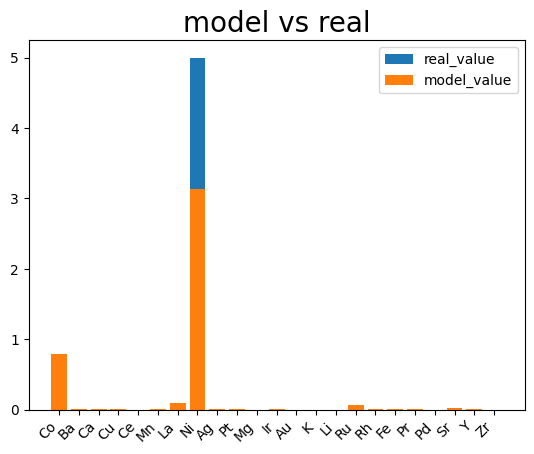

In [35]:
plt.bar(metal_columns, x_true_test[3],label = 'real_value')
plt.bar(metal_columns,x_hat_test[3],label = 'model_value')
plt.xticks(rotation=45,ha='right')
plt.title(f'model vs real',fontsize = 20)
plt.legend()
plt.show()